# ------------------------------ Resnet101 ------------------------------

### importing all the needed library

In [198]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation,ZeroPadding2D,Flatten,Conv2D,DepthwiseConv2D,AveragePooling2D, Dropout,MaxPooling2D, GlobalMaxPooling2D,BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import os
import cv2  
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

 ## Preprocessing
 * Assign the file path for validation, test and train set
 * Load the train , test and validation dataset and label them
 * Change the to array inorder to work feed it to the model
 * Split and norrmalize the data and split it to train , test, val set
 * Since we have small amount of data to train a really deep neroul network we need to do augmentation in order to generrate more training data

In [147]:
normal_train_file = '/<file path>/NORMAL'
abnormal_train_file = '/<file path>/PNEUMONIA'
normal_test_file  = "/<file path>/NORMAL"
abnormal_test_file = "/<file path>/PNEUMONIA"
normal_val_file = "/<file path>/NORMAL"
abnormal_val_file ="/<file path>/PNEUMONIA"


In [164]:
# Function to load images from a folder
def load_images_from_folder(folders,img_size):
    images = []
    labels =[]
    for folder in folders:
        for filename in os.listdir(folder):
            if filename.endswith('.jpeg'): 
                if folder.split('/')[-1] == "NORMAL":
                    labels.append(0)
                else:
                    labels.append(1)
                img = cv2.imread(os.path.join(folder, filename))
                img = cv2.resize(img, (img_size, img_size)) 
                if img is not None:
                    images.append(img)
    return images, labels


In [165]:
img_size = 64
folders= [normal_train_file,abnormal_train_file,normal_test_file,abnormal_test_file,normal_val_file,abnormal_val_file ]

images, labels = load_images_from_folder(folders,img_size)

In [166]:
images = np.array(images)
labels = np.array(labels)


In [167]:
X_train_orig,X_,Y_train,Y_ = train_test_split(images,labels,test_size=0.2, random_state = 42)
X_test_orig,X_val_orig,Y_test,Y_val = train_test_split(X_,Y_,test_size=0.5, random_state = 42)
del X_,Y_
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
X_val = X_val_orig / 255.
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))


number of training examples = 4684
number of test examples = 586
X_train shape: (4684, 64, 64, 3)
Y_train shape: (4684,)
X_test shape: (586, 64, 64, 3)
Y_test shape: (586,)
X_val shape: (586, 64, 64, 3)
Y_val shape: (586,)


In [168]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

###  Creating the model
* Create an identity block for my resnet that  has three layer (Depth -> point -> Batch norm -> relu)
* A convolution block for input and output dimansionality change
* Resnet101 wich has 101 layer identity and convolutional blocks stacked to each other

In [169]:

def identity_block(X, f, filters, initializer=random_uniform):
    
    # Load filters
    F1, F2, F3 = filters
    # Save the shortcut of X
    X_shortcut = X

    # First component of the main path
    # Depthwise + Pointwise Convolution (1x1)
    X = DepthwiseConv2D(kernel_size=1, strides=(1, 1), padding='valid', depthwise_initializer=initializer(seed=0))(inputs=X)
    X = Conv2D(filters=F1, kernel_size=1, strides=(1,1), padding="valid", kernel_initializer=initializer(seed=0))(inputs=X)
    X = BatchNormalization(axis=3)(inputs=X)
    X = Activation('relu')(inputs=X)

    # Second component of the main path
    # Depthwise + Pointwise Convolution (f x f)
    X = DepthwiseConv2D(kernel_size=f, strides=(1, 1), padding='same', depthwise_initializer=initializer(seed=0))(inputs=X)
    X = Conv2D(filters=F2, kernel_size=1, strides=(1,1), padding="valid", kernel_initializer=initializer(seed=0))(inputs=X)
    X = BatchNormalization(axis=3)(inputs=X)
    X = Activation('relu')(inputs=X)

    # Third component of the main path
    # Depthwise + Pointwise Convolution (1x1)
    X = DepthwiseConv2D(kernel_size=1, strides=(1, 1), padding='valid', depthwise_initializer=initializer(seed=0))(inputs=X)
    X = Conv2D(filters=F3, kernel_size=1, strides=(1,1), padding="valid", kernel_initializer=initializer(seed=0))(inputs=X)
    X = BatchNormalization(axis=3)(inputs=X)

    # Add shortcut value to the main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(inputs=X)

    return X



In [170]:
def convolution_block(X, f, filters, s = 2, initializer = glorot_uniform):

    F1, F2, F3 = filters

    X_shortcut = X

    #(I)Conv2D -> Batchnorm -> relu ->(II) Conv2d -> batchnorm ->relu -> (III) Conv2d -> batchnorm ->(IV) Conv2D -> batchnorm -> (V) Add -> relu
    #(I)
    X = DepthwiseConv2D(kernel_size=1, strides=(s, s), padding='valid', depthwise_initializer=initializer(seed=0))(inputs=X)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(inputs=X)
    X = BatchNormalization(axis = 3)(inputs=X)
    X = Activation('relu')(inputs=X)
    
    #(II)
    X = DepthwiseConv2D(kernel_size=(f,f), strides=(1, 1), padding='same', depthwise_initializer=initializer(seed=0))(inputs=X)
    X = Conv2D(filters = F2, kernel_size = (1,1),strides =(1,1), padding = "valid", kernel_initializer = initializer(seed=0) )(inputs=X)
    X = BatchNormalization(axis = 3)(inputs=X) 
    X = Activation('relu')(inputs=X)

    #(III)
    X = DepthwiseConv2D(kernel_size=(1,1), strides=(1, 1), padding='valid', depthwise_initializer=initializer(seed=0))(inputs=X)
    X = Conv2D(filters=F3, kernel_size =(1,1), strides =(1,1),padding="valid",kernel_initializer = initializer(seed=0) )(inputs=X)
    X = BatchNormalization(axis = 3)(inputs=X)
    
    #(IV)
    X_shortcut = DepthwiseConv2D(kernel_size=(1,1), strides=(s, s), padding='valid', depthwise_initializer=initializer(seed=0))(inputs=X_shortcut)
    X_shortcut = Conv2D(filters= F3, kernel_size= (1,1), strides =(1,1), padding= "valid", kernel_initializer = initializer(seed=0) )(inputs=X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)


    #(V)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(inputs=X)

    return X

In [201]:
def ResNet101(input_shape = (64,64,3), classes = 1,augmentation=data_augmenter(), training=False):
    
     
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # augment the data
    X = augmentation(X_input)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(inputs=X)
    X = BatchNormalization(axis = 3)(inputs=X)
    X = Activation('relu')(inputs=X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(inputs=X)

    # Stage 2
    X = convolution_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

   
    # stage 3
    
    X = convolution_block(X, f = 3, filters = [128,128,512], s = 2)
    
    # 3 `identity_block` 
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    # Stage 4
    
    # add 1 `convolutional_block` 
    X = convolution_block(X, f = 3, filters = [256,256,1024], s = 2)
    
    # the 22 `identity_block` 
    for i in range(22):
        X = identity_block(X, 3, [256, 256, 1024])
    

    # Stage 5 
    # add 1 `convolutional_block` 
    X = convolution_block(X, f = 3, filters = [512,512,2048 ], s = 2)
    
    # 2 `identity_block` 
    X = identity_block(X, 3,[512,512, 2048])
    X = identity_block(X, 3,[512,512, 2048])

    # AVGPOOL 
    X = AveragePooling2D(pool_size =(2,2))(inputs=X)
    

    
    # output layer
    X = Flatten()(inputs=X)
    X = Dropout(0.2)(X)
    X = Dense(1,activation= "sigmoid", kernel_initializer = glorot_uniform(seed=0))(inputs=X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [173]:

model = ResNet101(input_shape = (64, 64, 3))
print(model.summary())

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64, 3) │          0 │ input_layer_21[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 70, 70, 3) │          0 │ sequential_3[0][… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_992 (Conv2D) │ (None, 32, 32,    │      9,472 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_992[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_944      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 15, 15,    │          0 │ activation_944[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_9… │ (None, 15, 15,    │        128 │ max_pooling2d_20… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_993 (Conv2D) │ (None, 15, 15,    │      4,160 │ depthwise_conv2d… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_993[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_945      │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_9… │ (None, 15, 15,    │        640 │ activation_945[0… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_994 (Conv2D) │ (None, 15, 15,    │      4,160 │ depthwise_conv2d… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_994[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_946      │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_9… │ (None, 15, 15,    │        128 │ activation_946[0… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_9… │ (None, 15, 15,    │        128 │ max_pooling2d_20

 Total params: 23,849,857 (90.98 MB)

 Trainable params: 23,744,513 (90.58 MB)

 Non-trainable params: 105,344 (411.50 KB)

None


In [177]:
np.random.seed(1)
tf.random.set_seed(2)
base_learning_rate=0.00015
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [185]:
initial_epochs = 20
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train,Y_train, 
                    validation_data=(X_val,Y_val), 
                    epochs=initial_epochs ,
                    callbacks=[early_stopping],
                    batch_size = 32
                   )

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 556ms/step - accuracy: 0.9301 - loss: 0.1913 - val_accuracy: 0.4983 - val_loss: 1.2752
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 89s 607ms/step - accuracy: 0.9237 - loss: 0.1825 - val_accuracy: 0.9198 - val_loss: 0.2028
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 612ms/step - accuracy: 0.9352 - loss: 0.1815 - val_accuracy: 0.9130 - val_loss: 0.1989
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 627ms/step - accuracy: 0.9315 - loss: 0.1650 - val_accuracy: 0.9113 - val_loss: 0.1996
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 95s 646ms/step - accuracy: 0.9410 - loss: 0.1560 - val_accuracy: 0.9352 - val_loss: 0.1691
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 95s 644ms/step - accuracy: 0.9364 - loss: 0.1447 - val_accuracy: 0.6229 - val_loss: 0.8398
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 651ms/step - accuracy: 0.9417 - loss: 0.1514 - val_accuracy: 0.9232 - val_loss: 0.2161
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.9389 - loss: 0.1

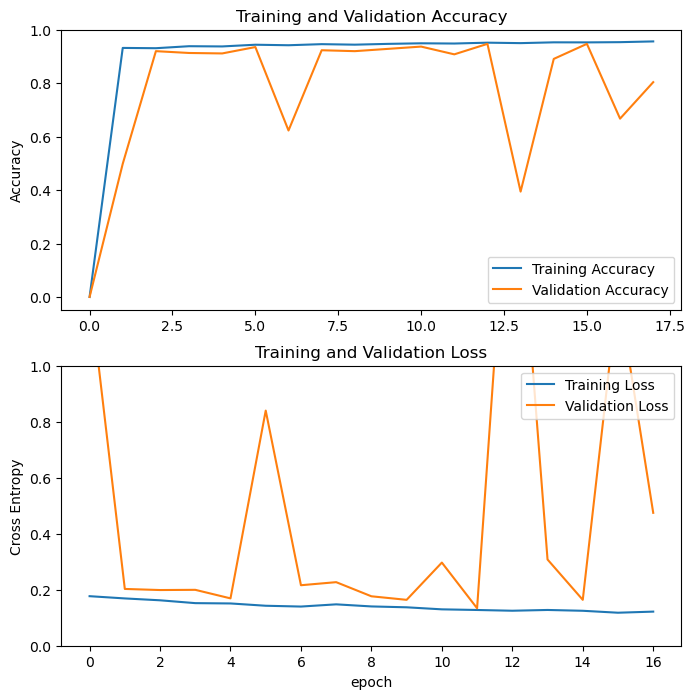

In [186]:
# plot the Accuracy and Loss

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# evaluate the model with the train , val and test set wich it has never seen
preds_train = model.evaluate(X_train,Y_train)
preds_val = model.evaluate(X_val,Y_val)
preds_test = model.evaluate(X_test,Y_test)


In [194]:
print (f"Train Loss =  {str(preds_train[0])}")
print (f"Train Test Accuracy = {str(preds_train[1])}\n")
print (f"Validation  Loss = {str(preds_val[0])}")
print (f"Validation Test Accuracy = {str(preds_val[1])}\n")
print (f"Test Loss = {str(preds_test[0])}")
print (f"Test set Test Accuracy = { str(preds_test[1])}")

Train Loss =  0.12734606862068176
Train Test Accuracy = 0.9519641399383545

Validation  Loss = 0.13382534682750702
Validation Test Accuracy = 0.947098970413208

Test Loss = 0.14469808340072632
Test set Test Accuracy = 0.9522184133529663


In [196]:
# the evaluation looks very good but in order to make sure it doing good i will use confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int) 

conf_matrix = confusion_matrix(Y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_classes))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
Confusion Matrix:
[[163  17]
 [ 11 395]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       180
           1       0.96      0.97      0.97       406

    accuracy                           0.95       586
   macro avg       0.95      0.94      0.94       586
weighted avg       0.95      0.95      0.95       586

